In [1]:
import numpy as np
import skimage
import skimage.io as skio
import scipy.signal as signal
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2
from cpselect.cpselect import cpselect
from scipy.spatial import Delaunay
import json
from scipy.interpolate import LinearNDInterpolator
import skimage.draw

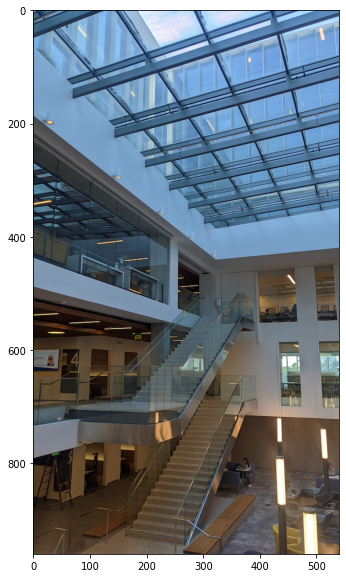

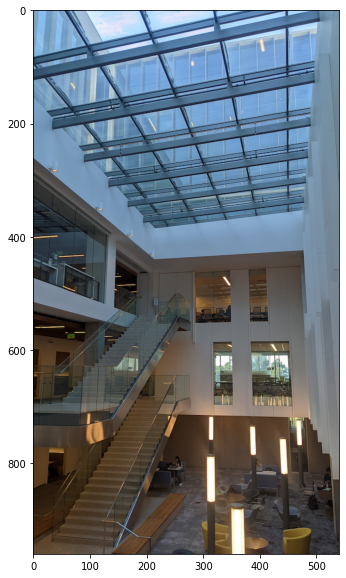

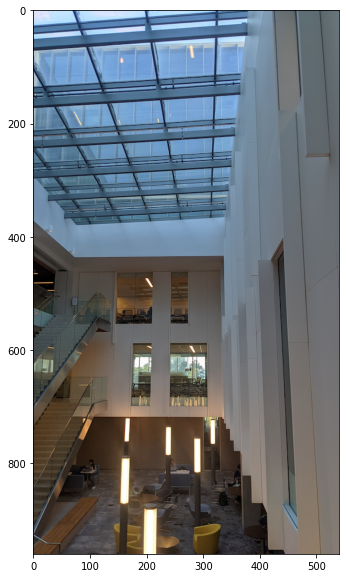

In [2]:
l = skio.imread('l.jpg')
m = skio.imread('m.jpg')
r = skio.imread('r.jpg')
plt.figure(figsize=(10,10))
plt.imshow(l)
plt.figure(figsize=(10,10))
plt.imshow(m)
plt.figure(figsize=(10,10))
plt.imshow(r)

In [3]:
f = open('l_m.json')
data = json.load(f)
leftPoints = np.array(data['im1Points'])[:,[1, 0]]
midPoints = np.array(data['im2Points'])[:,[1, 0]]

In [4]:
# im2Points = H * im1Points
def computeH(im1Points, im2Points):
    A = np.zeros((len(im1Points)*2, 8))
    b = np.zeros((len(im1Points)*2, 1))
    for i in range(len(im1Points)):
        pos = i*2
        x, y, = im1Points[i]
        x_prime, y_prime = im2Points[i]
        A[pos] = [x, y, 1, 0, 0, 0, -x*x_prime, -y*x_prime]
        A[pos+1] = [0, 0, 0, x, y, 1, -x*y_prime, -y*y_prime]
        b[pos] = x_prime
        b[pos+1] = y_prime
    return A, b

In [5]:
# transform leftPoints into midPoints basis
A, b = computeH(leftPoints, midPoints)

In [6]:
x = np.linalg.lstsq(A, b, rcond=None)[0]
H = np.append(x, [1])
H = H.reshape((3,3))
H

array([[ 1.09213736e+00,  1.38154245e-01, -5.34844827e+01],
       [-3.13964203e-02,  1.12857129e+00, -1.18087469e+02],
       [ 1.78092346e-05,  2.16637617e-04,  1.00000000e+00]])

In [7]:
p = H @ np.append(leftPoints, np.array([1]*4).reshape(-1, 1), axis=1).T

In [8]:
p = p / p[-1, :]

In [9]:
p.T

array([[940.,  39.,   1.],
       [449.,  59.,   1.],
       [459., 385.,   1.],
       [783., 394.,   1.]])

In [10]:
# from scipy.interpolate import LinearNDInterpolator
# y, x = np.mgrid[0:r.shape[0], 0:r.shape[1]]
# indices = np.vstack((y.flatten(), x.flatten())).T
# interp = LinearNDInterpolator(indices, r.reshape((-1, 3)))

In [11]:
from scipy.interpolate import LinearNDInterpolator
y, x = np.mgrid[0:l.shape[0], 0:l.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interp = LinearNDInterpolator(indices, l.reshape((-1, 3)))

In [12]:
corners = np.array([[0,0,1], [959, 0,1], [959, 539,1], [0, 539,1]]).T

In [13]:
coords = H @ corners

In [14]:
H

array([[ 1.09213736e+00,  1.38154245e-01, -5.34844827e+01],
       [-3.13964203e-02,  1.12857129e+00, -1.18087469e+02],
       [ 1.78092346e-05,  2.16637617e-04,  1.00000000e+00]])

In [15]:
coords

array([[-5.34844827e+01,  9.93875244e+02,  1.06834038e+03,
         2.09806556e+01],
       [-1.18087469e+02, -1.48196636e+02,  4.60103290e+02,
         4.90212457e+02],
       [ 1.00000000e+00,  1.01707906e+00,  1.13384673e+00,
         1.11676768e+00]])

In [16]:
# None is the same as np.newaxis
fixed_coords = coords / coords[None, -1, :]

In [17]:
# there are the leftpoints transformed into the middle image 
fixed_coords

array([[ -53.4844827 ,  977.18583224,  942.22645096,   18.78694739],
       [-118.08746926, -145.70807988,  405.78966919,  438.95652419],
       [   1.        ,    1.        ,    1.        ,    1.        ]])

In [18]:
# transform it back to get the coordinates in the left image
s = np.linalg.pinv(H) @ fixed_coords
s = s/s[None, -1, :]
np.round(s)

array([[ -0., 959., 959.,  -0.],
       [  0.,   0., 539., 539.],
       [  1.,   1.,   1.,   1.]])

In [19]:
fixed_coords = fixed_coords[:2, :] + 200

In [20]:
fixed_coords

array([[ 146.5155173 , 1177.18583224, 1142.22645096,  218.78694739],
       [  81.91253074,   54.29192012,  605.78966919,  638.95652419]])

In [21]:
corners.T[:,:2]

array([[  0,   0],
       [959,   0],
       [959, 539],
       [  0, 539]])

In [22]:
fixed_coords.T

array([[ 146.5155173 ,   81.91253074],
       [1177.18583224,   54.29192012],
       [1142.22645096,  605.78966919],
       [ 218.78694739,  638.95652419]])

In [23]:
coords

array([[-5.34844827e+01,  9.93875244e+02,  1.06834038e+03,
         2.09806556e+01],
       [-1.18087469e+02, -1.48196636e+02,  4.60103290e+02,
         4.90212457e+02],
       [ 1.00000000e+00,  1.01707906e+00,  1.13384673e+00,
         1.11676768e+00]])

In [24]:
corners = coords[4:len(coords),:2]
corners

array([], shape=(0, 2), dtype=float64)

In [25]:
corners.shape

(0, 2)

In [26]:
mask = skimage.draw.polygon2mask((1500, 700),fixed_coords.T).astype(int)

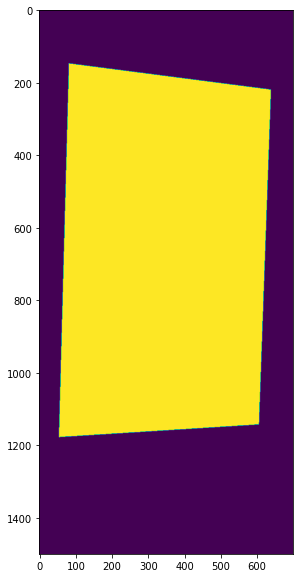

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [28]:
mask_coords = np.where(mask == 1)
mask_coords

(array([ 147,  147,  147, ..., 1177, 1177, 1177]),
 array([82, 83, 84, ..., 55, 56, 57]))

In [29]:
transformed_image = np.zeros((mask.shape[0], mask.shape[1], 3))
mask_matrix = np.vstack((np.vstack((mask_coords[0] - 200, mask_coords[1] - 200)), [1]*len(mask_coords[0])))
# basis = np.linalg.pinv(H) @ transformed_matrix 

new_coords = np.linalg.pinv(H) @ (mask_matrix)
new_coords = new_coords / new_coords[None, -1, :]
vals = interp(new_coords[0], new_coords[1])
transformed_image[mask_coords[0], mask_coords[1]] = vals
# y, x = np.mgrid[0:m.shape[0], 0:m.shape[1]]
# transformed_image[y+170, x+100] = m

In [30]:
leftPoints

array([[934, 167],
       [457, 172],
       [455, 498],
       [791, 520]])

In [31]:
midPoints

array([[940,  39],
       [449,  59],
       [459, 385],
       [783, 394]])

In [32]:
p

array([[940., 449., 459., 783.],
       [ 39.,  59., 385., 394.],
       [  1.,   1.,   1.,   1.]])

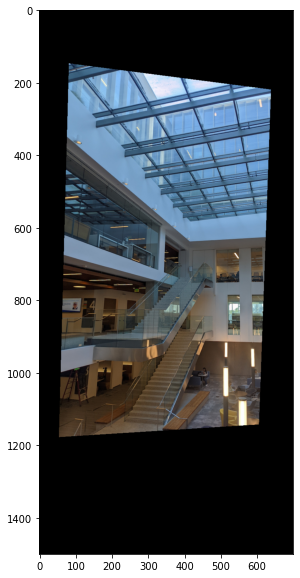

In [33]:
plt.figure(figsize=(10,10))
#plt.imshow(cv2.normalize(transformed_image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1))
plt.imshow(transformed_image.astype("uint8"))

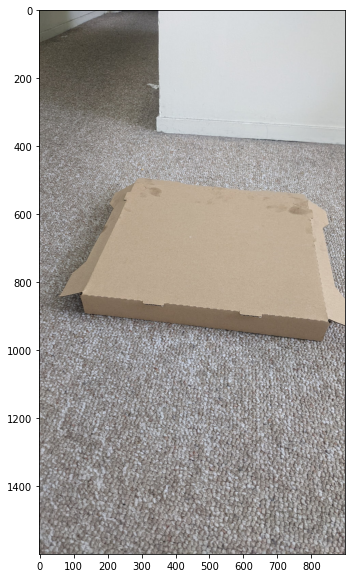

In [34]:
box = skio.imread('box.jpg')
plt.figure(figsize=(10,10))
plt.imshow(box)

In [35]:
f = open('box_box.json')
data = json.load(f)
boxpoints = np.array(data['im1Points'])[:,[1, 0]]

In [36]:
boxpoints

array([[840, 129],
       [509, 283],
       [546, 787],
       [917, 849]])

In [37]:
boxcorners = np.array([[900, 300], [400, 300], [400, 800], [900, 800]])

In [38]:
# project boxpoints onto boxcorners basis
A, b = computeH(boxpoints, boxcorners)

In [39]:
x = np.linalg.lstsq(A, b, rcond=None)[0]
H = np.append(x, [1])
H = H.reshape((3,3))

In [40]:
def warpImage(im, H, interp, margin_bias=0):
    # get the weighted corners in the basis image
    corners = np.array([[0, 0, 1], [0, im.shape[1], 1], [im.shape[0], im.shape[1], 1], [im.shape[0], 0, 1]])
    coords = H @ corners.T
    # undo the weights and get bias
    fixed_coords = coords / coords[None, -1, :]
    bias = abs(np.min(fixed_coords))
    fixed_coords = fixed_coords[:2, :] + bias
    axs = np.max(fixed_coords, axis=1).astype(int)
    y, x = axs[0], axs[1]
    # get mask of the projected im
    mask = skimage.draw.polygon2mask((y+margin_bias, x+margin_bias),fixed_coords.T).astype(int)
    plt.figure(figsize=(10,10))
    plt.imshow(mask)
    mask_coords = np.where(mask == 1)
    transformed_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    mask_matrix = np.vstack((np.vstack((mask_coords[0] - bias, mask_coords[1] - bias)), [1]*len(mask_coords[0])))
    # interpolate to get the warped pixels from the original image
    new_coords = np.linalg.pinv(H) @ (mask_matrix)
    new_coords = new_coords / new_coords[None, -1, :]
    vals = interp(new_coords[0], new_coords[1])
    transformed_image[mask_coords[0], mask_coords[1]] = vals
    return transformed_image, bias

In [42]:
y, x = np.mgrid[0:box.shape[0], 0:box.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpbox = LinearNDInterpolator(indices, box.reshape((-1, 3)))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3848919310.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_box.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


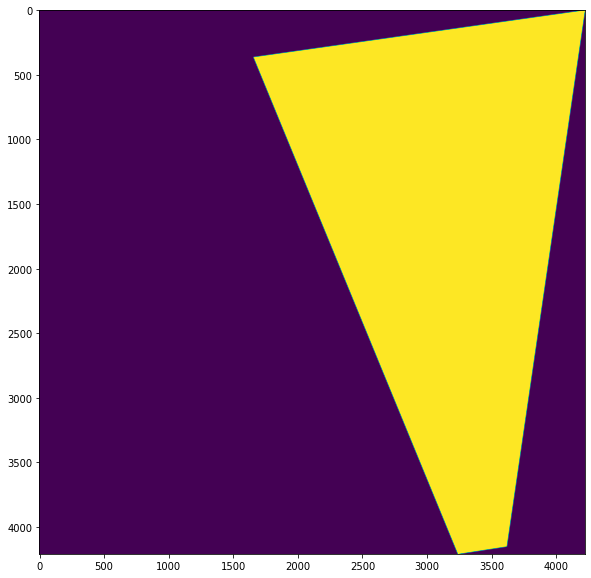

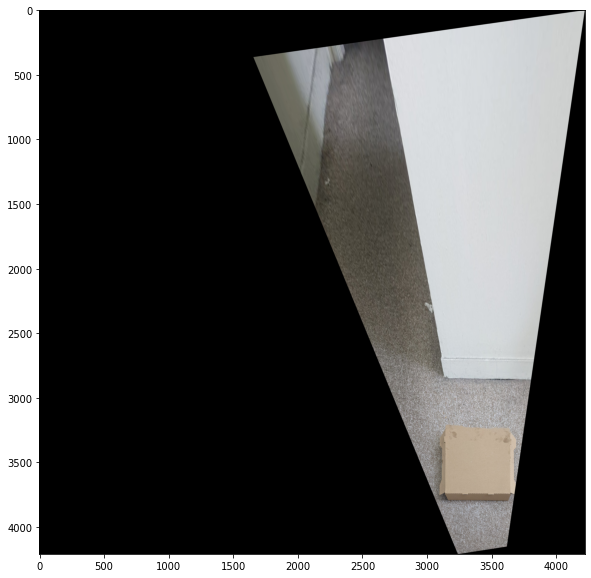

In [44]:
new_box, _ = warpImage(box, H, interpbox)
plt.figure(figsize=(10,10))
plt.imshow(new_box.astype(int))

In [45]:
corners = np.append(boxpoints, np.array([1]*4).reshape(-1, 1), axis=1)
corners

array([[840, 129,   1],
       [509, 283,   1],
       [546, 787,   1],
       [917, 849,   1]])

In [46]:
# transform box onto square basis
# corners = np.array([[1599, 0, 1], [0, 899, 1], [0, 0, 1], [1599, 899, 1]])
corners = np.array([[0, 0, 1], [0, 899, 1], [1599, 899, 1], [1599, 0, 1]])
coords = H @ corners.T

In [47]:
fixed_coords = coords / coords[None, -1, :]

In [48]:
fixed_coords

array([[-2.47954629e+03, -2.84278242e+03,  1.30771675e+03,
         1.36619874e+03],
       [-1.18643485e+03,  1.37566226e+03,  7.73094761e+02,
         3.94521716e+02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00]])

In [49]:
bias = abs(np.min(fixed_coords)) + 10
bias

2852.7824165443085

In [50]:
s = np.linalg.pinv(H) @ fixed_coords
s = s/s[None, -1, :]
np.round(s)

array([[-0.000e+00,  0.000e+00,  1.599e+03,  1.599e+03],
       [ 0.000e+00,  8.990e+02,  8.990e+02,  0.000e+00],
       [ 1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00]])

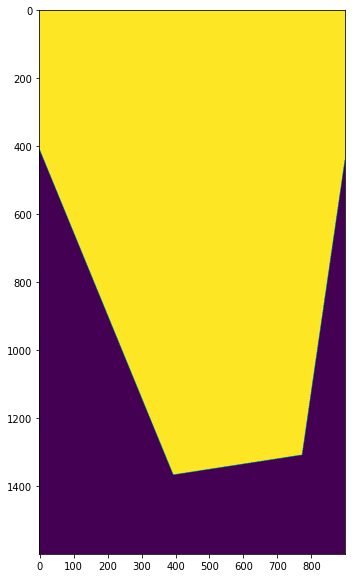

In [51]:
fixed_coords = fixed_coords[:2, :]
mask = skimage.draw.polygon2mask((1600, 900),fixed_coords.T).astype(int)
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [52]:
mask_coords = np.where(mask == 1)
mask_coords

(array([   0,    0,    0, ..., 1365, 1365, 1366]),
 array([  0,   1,   2, ..., 401, 402, 395]))

In [53]:
transformed_image = np.zeros((mask.shape[0], mask.shape[1], 3))
mask_matrix = np.vstack((np.vstack((mask_coords[0], mask_coords[1])), [1]*len(mask_coords[0])))

new_coords = np.linalg.pinv(H) @ (mask_matrix)
new_coords = new_coords / new_coords[None, -1, :]
vals = interpbox(new_coords[0], new_coords[1])
transformed_image[mask_coords[0], mask_coords[1]] = vals

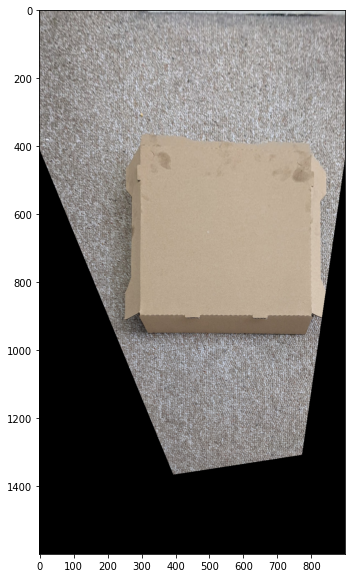

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(transformed_image.astype(int))

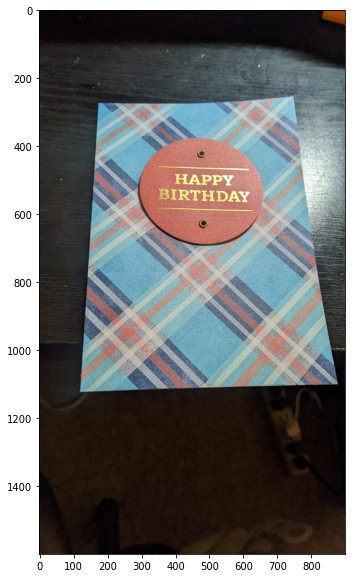

In [55]:
geo = skio.imread('card.jpg')
plt.figure(figsize=(10,10))
plt.imshow(geo)

In [56]:
f = open('card_card.json')
data = json.load(f)
geopoints = np.array(data['im1Points'])[:,[1, 0]]

In [57]:
geopoints

array([[ 275,  177],
       [ 256,  748],
       [1124,  123],
       [1102,  880]])

In [58]:
geo.shape

(1600, 900, 3)

In [59]:
# ipad = np.array([[0, 0], [0, 500], [750, 0], [750, 500]])

In [60]:
# ipad = np.array([[500, 100], [900, 100], [900, 800], [500, 800]])

In [61]:
# ipad = np.array([[0, 0], [0, 300], [225, 0], [225, 300]])

In [62]:
ipad = np.array([[0, 0], [0, 600], [800, 0], [800, 600]])

In [63]:
A, b = computeH(geopoints, ipad)

In [64]:
x = np.linalg.lstsq(A, b, rcond=None)[0]
H = np.append(x, [1])
H = H.reshape((3,3))

In [67]:
y, x = np.mgrid[0:geo.shape[0], 0:geo.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpgeo = LinearNDInterpolator(indices, geo.reshape((-1, 3)))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1979347320.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_card.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


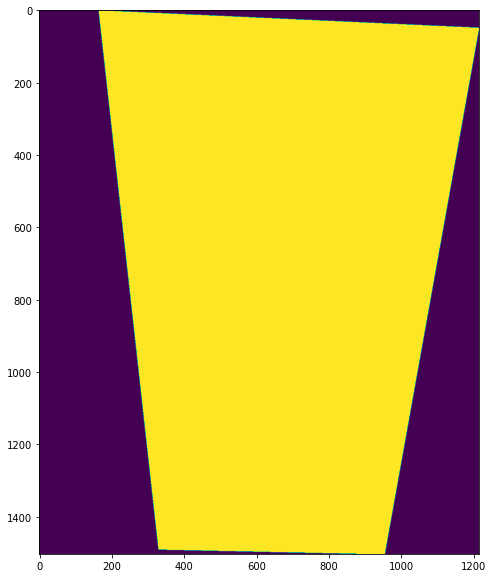

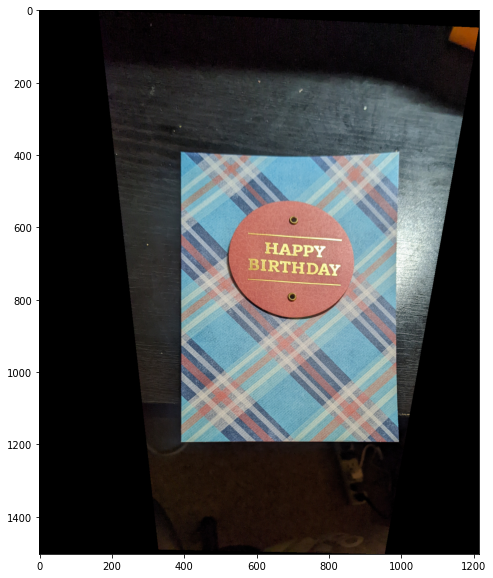

In [70]:
new_card, _ = warpImage(geo, H, interpgeo)
plt.figure(figsize=(10,10))
plt.imshow(new_card.astype(int))

In [71]:
corners = np.append(geopoints, np.array([1]*4).reshape(-1, 1), axis=1)

In [72]:
geo.shape

(1600, 900, 3)

In [73]:
corners

array([[ 275,  177,    1],
       [ 256,  748,    1],
       [1124,  123,    1],
       [1102,  880,    1]])

In [74]:
###### transform geo into box coordinates
# corners = np.append(corners, np.array([[0, 0, 1], [0, 899, 1], [1599, 899, 1], [1599, 0, 1]]), axis=0)
# corners = np.array([[1599, 0, 1], [0, 0, 1], [0, 899, 1], [1599, 899, 1]])
# corners = np.array([[0, 0, 1], [1599, 0, 1], [1599, 899, 1], [0, 899, 1]])
# corners = np.array([[0, 0, 1], [0, 999, 1], [495, 999, 1], [495, 0, 1]])
corners = np.array([[0, 0, 1], [0, 899, 1], [1599, 899, 1], [1599, 0, 1]])
# coords = H @ indices.T
coords = H @ corners.T

In [75]:
coords.shape

(3, 4)

In [76]:
corners

array([[   0,    0,    1],
       [   0,  899,    1],
       [1599,  899,    1],
       [1599,    0,    1]])

In [77]:
corners

array([[   0,    0,    1],
       [   0,  899,    1],
       [1599,  899,    1],
       [1599,    0,    1]])

In [78]:
fixed_coords = coords / coords[None, -1, :]

In [79]:
s = np.linalg.pinv(H) @ fixed_coords
s = s/s[None, -1, :]
np.round(s)

array([[ 0.000e+00,  0.000e+00,  1.599e+03,  1.599e+03],
       [-0.000e+00,  8.990e+02,  8.990e+02,  0.000e+00],
       [ 1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00]])

In [80]:
fixed_coords

array([[-3.94258532e+02, -3.46077811e+02,  1.10882413e+03,
         1.09570861e+03],
       [-2.30427040e+02,  8.20006181e+02,  5.59760653e+02,
        -6.51063401e+01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00]])

In [81]:
np.min(fixed_coords)

-394.2585316920698

In [82]:
fixed_coords = fixed_coords[:2, :] + 400
fixed_coords

array([[   5.74146831,   53.92218891, 1508.82413108, 1495.70861184],
       [ 169.57296012, 1220.00618144,  959.76065268,  334.89365992]])

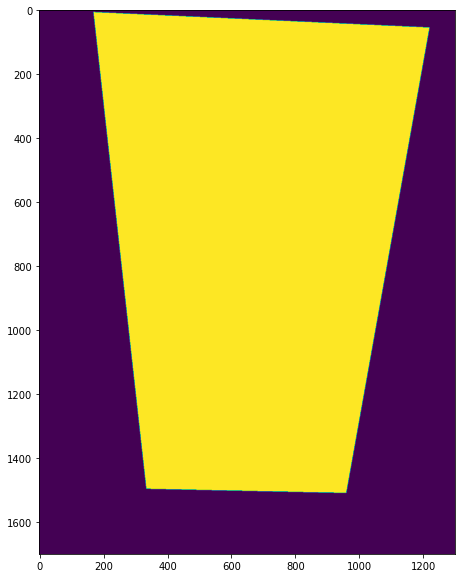

In [83]:
mask = skimage.draw.polygon2mask((1700, 1300),fixed_coords.T).astype(int)
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [84]:
fixed_coords

array([[   5.74146831,   53.92218891, 1508.82413108, 1495.70861184],
       [ 169.57296012, 1220.00618144,  959.76065268,  334.89365992]])

In [85]:
mask_coords = np.where(mask == 1)
mask_coords

(array([   6,    6,    6, ..., 1508, 1508, 1508]),
 array([170, 171, 172, ..., 957, 958, 959]))

In [86]:
transformed_image = np.zeros((mask.shape[0], mask.shape[1], 3))
mask_matrix = np.vstack((np.vstack((mask_coords[0]-400, mask_coords[1]-400)), [1]*len(mask_coords[0])))
new_coords = np.linalg.pinv(H) @ (mask_matrix)
new_coords = new_coords / new_coords[None, -1, :]
vals = interpgeo(new_coords[0], new_coords[1])
transformed_image[mask_coords[0], mask_coords[1]] = vals

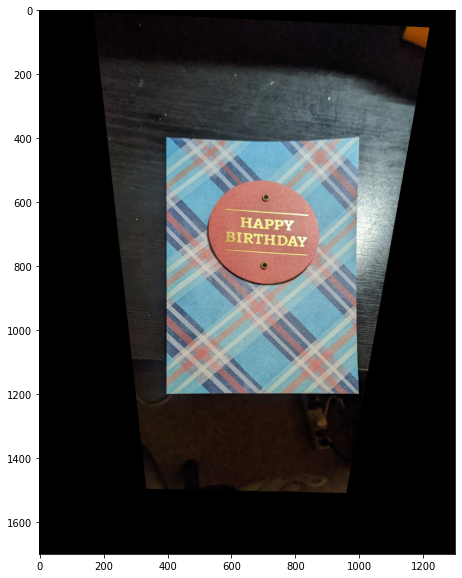

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.normalize(transformed_image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1))

### Blend the images into a mosaic

In [88]:
def weightAvg(image1, image2):
    # Check if the images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same shape")

    # Create a binary mask where pixels are 1 if both images are non-zero
    non_zero_mask = (image1 != 0) & (image2 != 0)
    single_im_mask = ((image1 == 0) & (image2 != 0)) | (((image1 != 0) & (image2 == 0)))

    # Initialize the result array with zeros
    result = np.zeros(image1.shape, dtype=np.float64)

    # Add non-zero pixels from both images and divide by 2
    result[non_zero_mask] = (image1[non_zero_mask] + image2[non_zero_mask]) / 2.0
    result[single_im_mask] = image1[single_im_mask] + image2[single_im_mask]

    return result

In [89]:
l = skio.imread('l.jpg')
m = skio.imread('m.jpg')
r = skio.imread('r.jpg')
# plt.figure(figsize=(10,10))
# plt.imshow(l)
# plt.figure(figsize=(10,10))
# plt.imshow(m)
# plt.figure(figsize=(10,10))
# plt.imshow(r)

In [90]:
f = open('l_m.json')
data = json.load(f)
leftPoints = np.array(data['im1Points'])[:,[1, 0]]
midPoints = np.array(data['im2Points'])[:,[1, 0]]

In [91]:
A, b = computeH(leftPoints, midPoints)
x = np.linalg.lstsq(A, b, rcond=None)[0]
H = np.append(x, [1])
H = H.reshape((3,3))
H

array([[ 1.09213736e+00,  1.38154245e-01, -5.34844827e+01],
       [-3.13964203e-02,  1.12857129e+00, -1.18087469e+02],
       [ 1.78092346e-05,  2.16637617e-04,  1.00000000e+00]])

In [92]:
x = np.linalg.lstsq(A, b, rcond=None)[0]
H = np.append(x, [1])
H = H.reshape((3,3))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/2946855212.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_ww.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


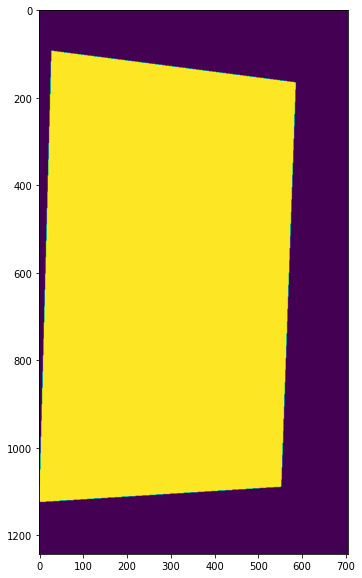

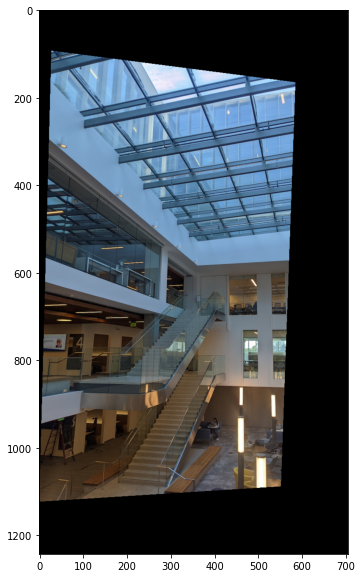

In [93]:
new_ww, shift = warpImage(l, H, interp, 120)
plt.figure(figsize=(10,10))
plt.imshow(new_ww.astype(int))

In [94]:
# y, x = np.mgrid[0:m.shape[0], 0:m.shape[1]]
# new_m = np.zeros_like(new_ww)
# bias1 = 139
# bias2 = 149
# new_m[y+bias1, x+bias2] = m
# # test = (new_ww + new_m) / 2
# test = weightAvg(new_ww, new_m)
# plt.figure(figsize=(10,10))
# plt.imshow(test.astype(int))

In [95]:
p = np.array([[934, 167, 1]])
new_p = H @ p.T
# undo the weights and get bias
new_p = new_p / new_p[None, -1, :] + shift
new_p

array([[1085.73639722],
       [ 184.73639722],
       [ 146.73639722]])

In [96]:
shift

145.7363972182587

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1158600436.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(test.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


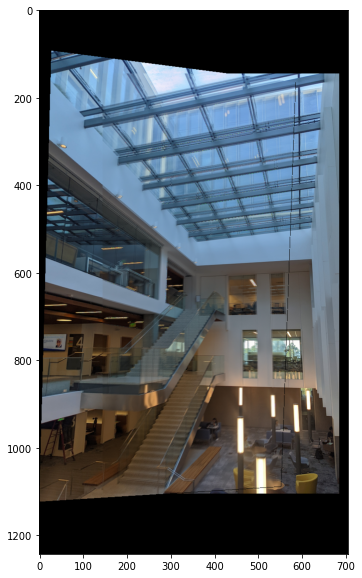

In [97]:
y, x = np.mgrid[0:m.shape[0], 0:m.shape[1]]
new_m = np.zeros_like(new_ww)
bias1 = int(shift)
bias2 = int(shift)
new_m[y+bias1, x+bias2] = m
# test = (new_ww + new_m) / 2
test = weightAvg(new_ww, new_m)
plt.figure(figsize=(10,10))
plt.imshow(test.astype(int))

In [98]:
f = open('r_m.json')
data = json.load(f)
rightP = np.array(data['im1Points'])[:,[1, 0]]
mP = np.array(data['im2Points'])[:,[1, 0]]

In [99]:
A, b = computeH(rightP, mP)
x = np.linalg.lstsq(A, b, rcond=None)[0]
H2 = np.append(x, [1])
H2 = H2.reshape((3,3))
H2

array([[ 9.30042625e-01, -1.22938944e-01,  2.97421230e+01],
       [ 2.80210916e-02,  8.83190105e-01,  1.29484297e+02],
       [-2.50751802e-05, -2.00079233e-04,  1.00000000e+00]])

In [100]:
x = np.linalg.lstsq(A, b, rcond=None)[0]
H2 = np.append(x, [1])
H2 = H2.reshape((3,3))

In [101]:
y, x = np.mgrid[0:r.shape[0], 0:r.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpR = LinearNDInterpolator(indices, r.reshape((-1, 3)))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/2416548768.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_ww2.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


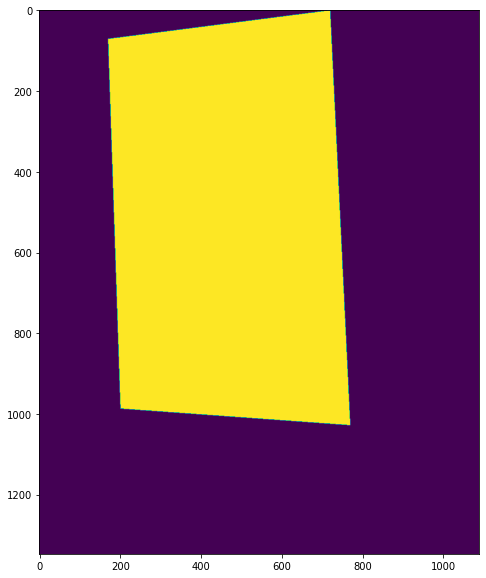

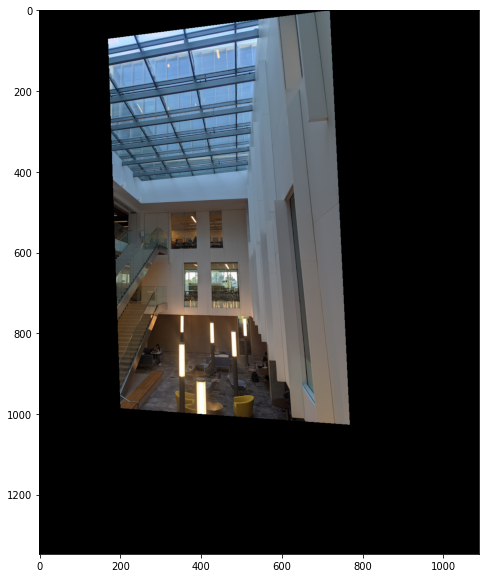

In [102]:
new_ww2, shift2 = warpImage(r, H2, interpR, 320)
plt.figure(figsize=(10,10))
plt.imshow(new_ww2.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3552417245.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(test2.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


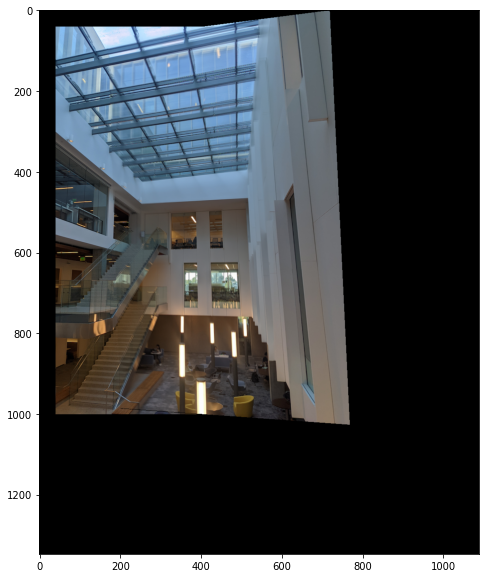

In [103]:
y, x = np.mgrid[0:m.shape[0], 0:m.shape[1]]
new_m2 = np.zeros_like(new_ww2)
bias1 = int(shift2)
bias2 = int(shift2)
new_m2[y+bias1, x+bias2] = m
# test2 = (new_ww2 + new_m2) / 2
test2 = weightAvg(new_ww2, new_m2)
plt.figure(figsize=(10,10))
plt.imshow(test2.astype(int))

In [104]:
print(leftPoints)
print(midPoints)
print(mP)
print(rightP)

[[934 167]
 [457 172]
 [455 498]
 [791 520]]
[[940  39]
 [449  59]
 [459 385]
 [783 394]]
[[931 207]
 [458 382]
 [916 491]
 [172 161]]
[[942  50]
 [463 245]
 [909 331]
 [155  29]]


In [105]:
p2 = np.array([[463, 245, 1]])
new_p2 = H2 @ p2.T
# undo the weights and get bias
new_p2 = new_p2 / new_p2[None, -1, :] + shift2
new_p2.astype(int)

array([[499],
       [423],
       [ 42]])

In [106]:
p = np.array([[455, 498, 1]])
new_p = H @ p.T
# undo the weights and get bias
new_p = new_p / new_p[None, -1, :] + shift
new_p.astype(int)

array([[604],
       [530],
       [146]])

In [111]:
shift3 = (new_p2-new_p)[:2]
shift3

array([[-105.65269231],
       [-107.65269231]])

In [112]:
shift

145.7363972182587

In [113]:
shift2

41.0837049045137

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/4259201186.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias1 = int(shift3[0])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/4259201186.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias2 = int(shift3[1])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/4259201186.py:14: RuntimeWarning: invalid value encountered in cast
  plt.imshow(combine[:1200,:1000,:].astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


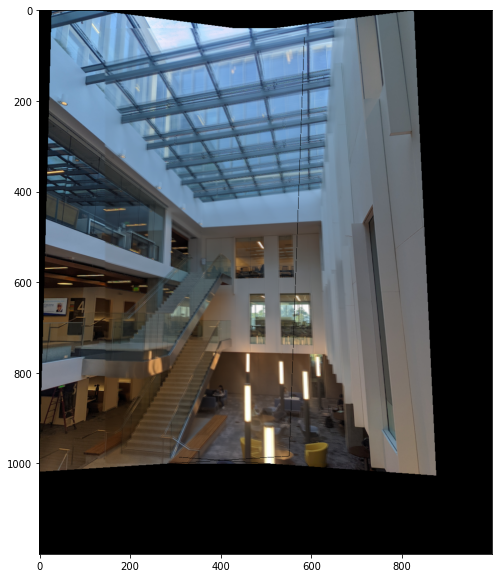

In [114]:
y, x = np.mgrid[0:test.shape[0], 0:test.shape[1]]
# new_m3 = np.zeros_like(new_ww2)
new_m3 = np.zeros((1500, 1300, 3))
bias1 = int(shift3[0])
bias2 = int(shift3[1])
y2, x2 = np.mgrid[0:test2.shape[0], 0:test2.shape[1]]
# test3 = np.zeros_like(test2)
test3 = np.zeros((1500, 1300, 3))
test3[y2, x2-bias2] = test2
new_m3[y+bias1, x] = test
# combine = (3/4*test3 + 3/4*new_m3)
combine = weightAvg(test3, new_m3)
plt.figure(figsize=(10,10))
plt.imshow(combine[:1200,:1000,:].astype(int))

In [115]:
lww = skio.imread('lww.jpg')
mww = skio.imread('mww.jpg')
rww = skio.imread('rww.jpg')

f = open('lww_mww.json')
data = json.load(f)
lP = np.array(data['im1Points'])[:,[1, 0]]
mP = np.array(data['im2Points'])[:,[1, 0]]
f = open('rww_mww.json')
data = json.load(f)
rP = np.array(data['im1Points'])[:,[1, 0]]
midP = np.array(data['im2Points'])[:,[1, 0]]

A1, b1 = computeH(lP, mP)
x = np.linalg.lstsq(A1, b1, rcond=None)[0]
H3 = np.append(x, [1])
H3 = H3.reshape((3,3))
A2, b2 = computeH(rP, midP)
x = np.linalg.lstsq(A2, b2, rcond=None)[0]
H4 = np.append(x, [1])
H4 = H4.reshape((3,3))

x = np.linalg.lstsq(A1, b1, rcond=None)[0]
H3 = np.append(x, [1])
H3 = H3.reshape((3,3))
x = np.linalg.lstsq(A2, b2, rcond=None)[0]
H4 = np.append(x, [1])
H4 = H4.reshape((3,3))

lcar = skio.imread('lcar.jpg')
mcar = skio.imread('mcar.jpg')
rcar = skio.imread('rcar.jpg')

f = open('lcar_mcar.json')
data = json.load(f)
lcarP = np.array(data['im1Points'])[:,[1, 0]]
mcarP1 = np.array(data['im2Points'])[:,[1, 0]]
f = open('rcar_mcar.json')
data = json.load(f)
rcarP = np.array(data['im1Points'])[:,[1, 0]]
mcarP2 = np.array(data['im2Points'])[:,[1, 0]]

A3, b3 = computeH(lcarP, mcarP1)
x = np.linalg.lstsq(A3, b3, rcond=None)[0]
H5 = np.append(x, [1])
H5 = H5.reshape((3,3))
A4, b4 = computeH(rcarP, mcarP2)
x = np.linalg.lstsq(A4, b4, rcond=None)[0]
H6 = np.append(x, [1])
H6 = H6.reshape((3,3))

x = np.linalg.lstsq(A3, b3, rcond=None)[0]
H5 = np.append(x, [1])
H5 = H5.reshape((3,3))
x = np.linalg.lstsq(A4, b4, rcond=None)[0]
H6 = np.append(x, [1])
H6 = H6.reshape((3,3))

In [116]:
y, x = np.mgrid[0:lww.shape[0], 0:lww.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpLWW = LinearNDInterpolator(indices, lww.reshape((-1, 3)))

In [117]:
y, x = np.mgrid[0:rww.shape[0], 0:rww.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpRWW = LinearNDInterpolator(indices, rww.reshape((-1, 3)))

In [118]:
y, x = np.mgrid[0:lcar.shape[0], 0:lcar.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpLcar = LinearNDInterpolator(indices, lcar.reshape((-1, 3)))

In [119]:
y, x = np.mgrid[0:rcar.shape[0], 0:rcar.shape[1]]
indices = np.vstack((y.flatten(), x.flatten())).T
interpRcar = LinearNDInterpolator(indices, rcar.reshape((-1, 3)))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1719635798.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_ww3.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


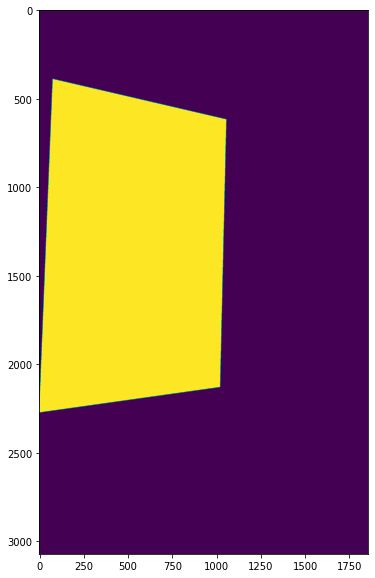

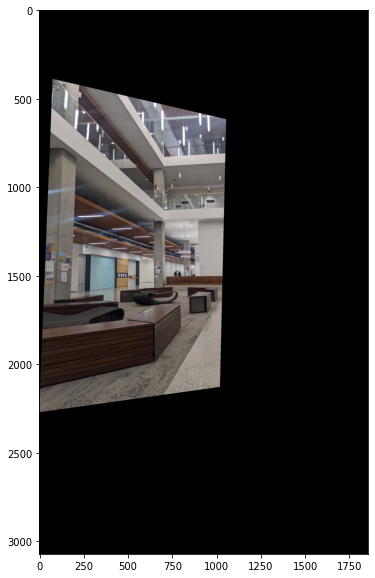

In [120]:
new_ww3, shift3 = warpImage(lww, H3, interpLWW, 800)
plt.figure(figsize=(10,10))
plt.imshow(new_ww3.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/721438549.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_ww4.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


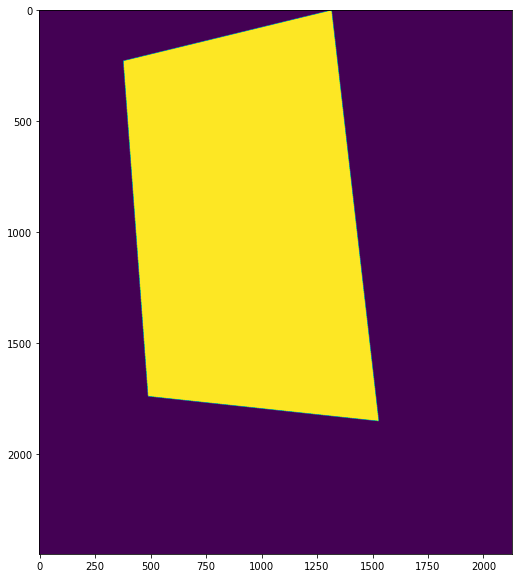

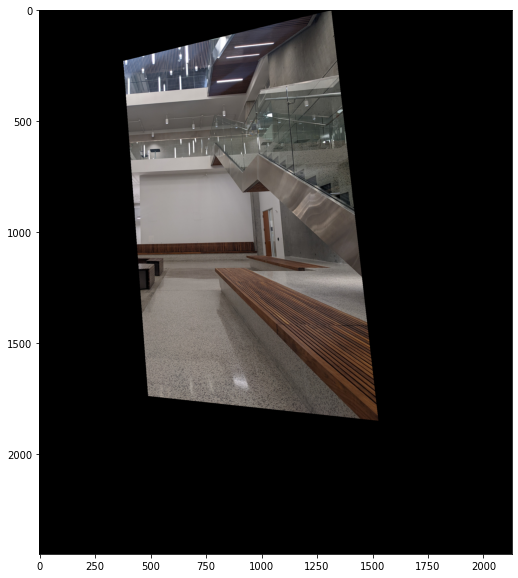

In [121]:
new_ww4, shift4 = warpImage(rww, H4, interpRWW, 600)
plt.figure(figsize=(10,10))
plt.imshow(new_ww4.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/2086277000.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_car1.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


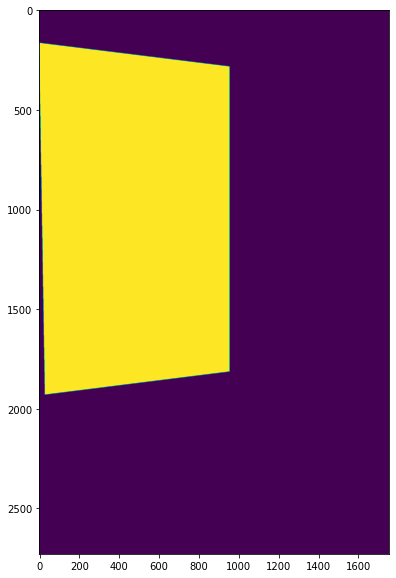

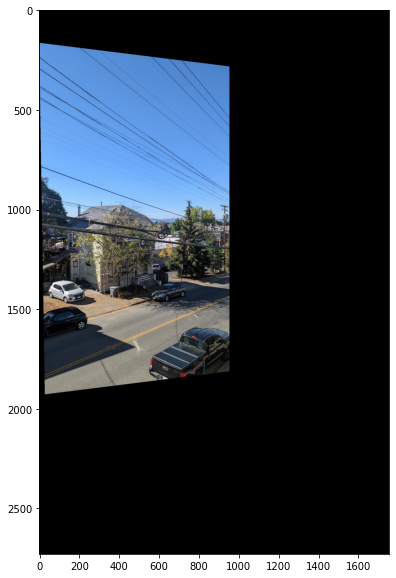

In [122]:
new_car1, shift6 = warpImage(lcar, H5, interpLcar, 800)
plt.figure(figsize=(10,10))
plt.imshow(new_car1.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/767234806.py:3: RuntimeWarning: invalid value encountered in cast
  plt.imshow(new_car2.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


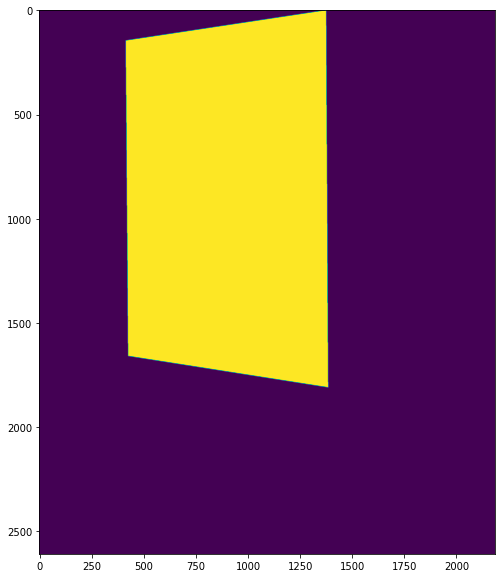

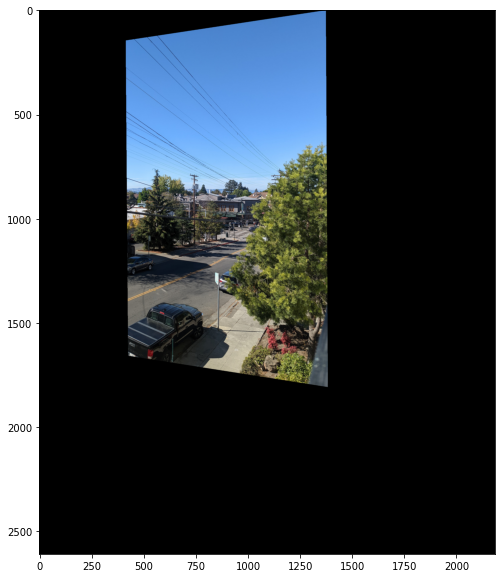

In [123]:
new_car2, shift7 = warpImage(rcar, H6, interpRcar, 800)
plt.figure(figsize=(10,10))
plt.imshow(new_car2.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3525711636.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(waywest.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


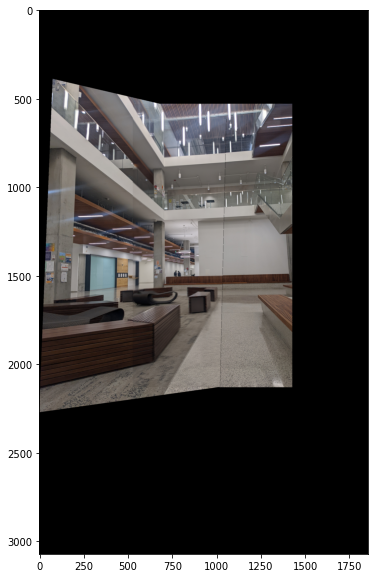

In [124]:
y, x = np.mgrid[0:mww.shape[0], 0:mww.shape[1]]
mid = np.zeros_like(new_ww3)
bias1 = int(shift3)
bias2 = int(shift3)
mid[y+bias1, x+bias2] = mww
# waywest = (new_ww3 + mid) / 2
waywest = weightAvg(new_ww3, mid)
plt.figure(figsize=(10,10))
plt.imshow(waywest.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/2555330026.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(waywest2.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


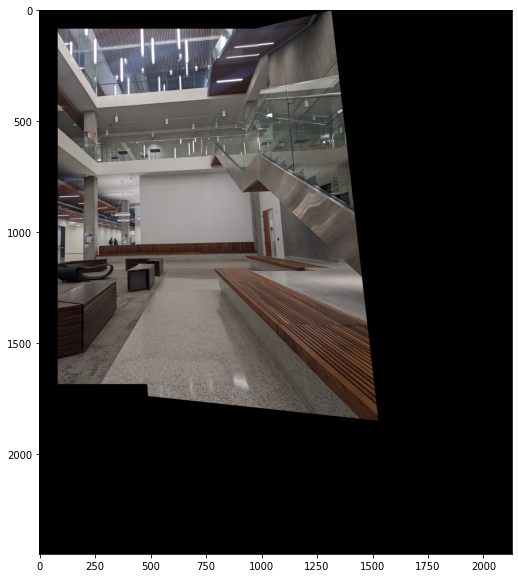

In [125]:
y, x = np.mgrid[0:mww.shape[0], 0:mww.shape[1]]
mid2 = np.zeros_like(new_ww4)
bias1 = int(shift4)
bias2 = int(shift4)
mid2[y+bias1, x+bias2] = mww
# waywest2 = (new_ww4 + mid2) / 2
waywest2 = weightAvg(new_ww4, mid2)
plt.figure(figsize=(10,10))
plt.imshow(waywest2.astype(int))

In [126]:
shift3

529.1484411307862

In [127]:
np.max(y+bias1)

1683

In [128]:
new_ww4.shape

(2449, 2128, 3)

In [129]:
new_ww3.shape

(3070, 1856, 3)

In [130]:
print(lP)
print(mP)
print(midP)
print(rP)

[[748 692]
 [659 495]
 [212 651]
 [500 836]]
[[772 317]
 [668 118]
 [240 291]
 [544 459]]
[[ 542  457]
 [ 168  701]
 [1079  710]
 [1034  476]]
[[ 462  146]
 [ 124  424]
 [1022  355]
 [ 971  125]]


In [131]:
p4 = np.array([[462, 146, 1]])
new_p4 = H4 @ p4.T
# undo the weights and get bias
new_p4 = new_p4 / new_p4[None, -1, :] + shift4
new_p4.astype(int)

array([[626],
       [541],
       [ 85]])

In [132]:
p3 = np.array([[500, 836, 1]])
new_p3 = H3 @ p3.T
# undo the weights and get bias
new_p3 = new_p3 / new_p3[None, -1, :] + shift3
new_p3.astype(int)

array([[1073],
       [ 988],
       [ 530]])

In [133]:
shift5 = (new_p4-new_p3)[:2]
shift5

array([[-446.83624693],
       [-446.83624694]])

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1980553587.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias1 = int(shift5[0])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1980553587.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias2 = int(shift5[1])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1980553587.py:14: RuntimeWarning: invalid value encountered in cast
  plt.imshow(combine2[:2000,:2000,:].astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


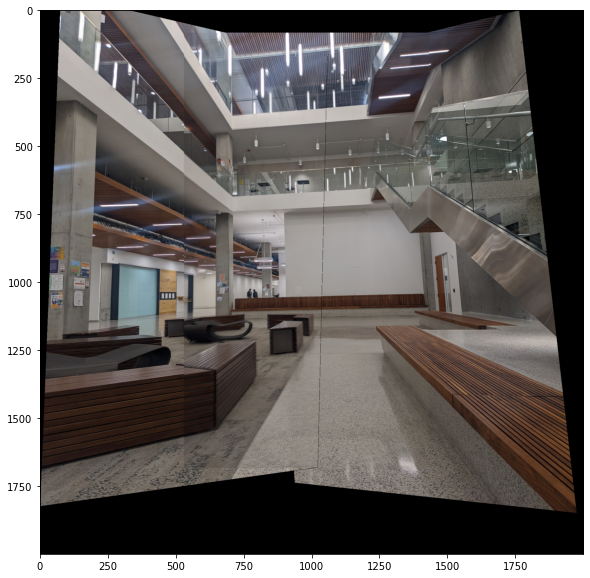

In [134]:
y, x = np.mgrid[0:waywest.shape[0], 0:waywest.shape[1]]
# new_m3 = np.zeros_like(new_ww2)
waywest3 = np.zeros((3100, 3000, 3))
bias1 = int(shift5[0])
bias2 = int(shift5[1])
y2, x2 = np.mgrid[0:waywest2.shape[0], 0:waywest2.shape[1]]
# test3 = np.zeros_like(test2)
waywest4 = np.zeros((3100, 3000, 3))
waywest4[y2, x2-bias2] = waywest2
waywest3[y+bias1, x] = waywest
# combine2 = (3/4*waywest3 + 3/4*waywest4)
combine2 = weightAvg(waywest3, waywest4)
plt.figure(figsize=(10,10))
plt.imshow(combine2[:2000,:2000,:].astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/1718271112.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(car1.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


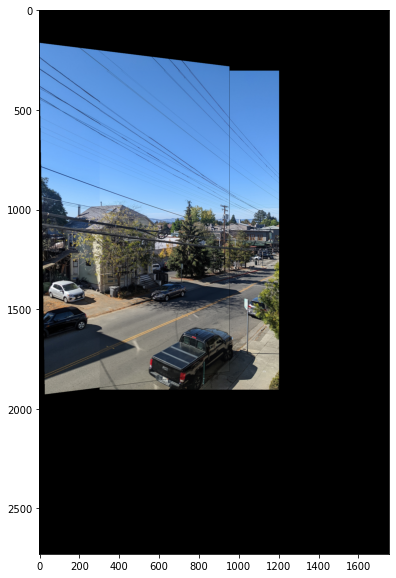

In [135]:
y, x = np.mgrid[0:mcar.shape[0], 0:mcar.shape[1]]
midcar1 = np.zeros_like(new_car1)
bias1 = int(shift6)
bias2 = int(shift6)
midcar1[y+bias1, x+bias2] = mcar
# car1 = (new_car1 + midcar1) / 2
car1 = weightAvg(new_car1, midcar1)
plt.figure(figsize=(10,10))
plt.imshow(car1.astype(int))

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3106848374.py:9: RuntimeWarning: invalid value encountered in cast
  plt.imshow(car2.astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


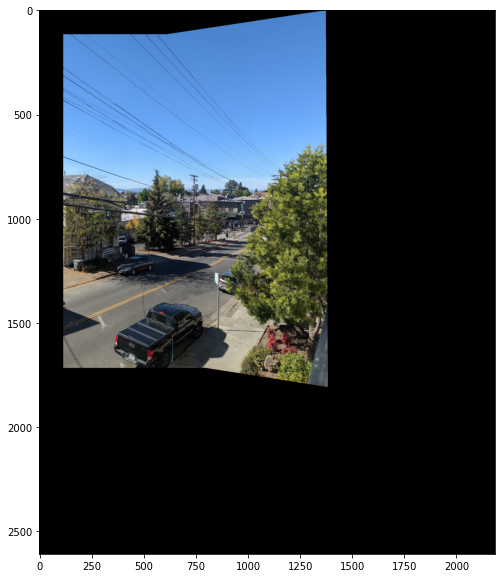

In [136]:
y, x = np.mgrid[0:mcar.shape[0], 0:mcar.shape[1]]
midcar2 = np.zeros_like(new_car2)
bias1 = int(shift7)
bias2 = int(shift7)
midcar2[y+bias1, x+bias2] = mcar
# car2 = (new_car2 + midcar2) / 2
car2 = weightAvg(new_car2, midcar2)
plt.figure(figsize=(10,10))
plt.imshow(car2.astype(int))

In [137]:
print(lcarP)
print(mcarP1)
print(mcarP2)
print(rcarP)

[[1391  717]
 [ 721  876]
 [ 709  259]
 [1116  294]]
[[1328  482]
 [ 677  629]
 [ 658    8]
 [1084   51]]
[[1328  482]
 [ 823  818]
 [ 676  629]
 [ 968  419]]
[[1353  188]
 [ 833  521]
 [ 689  342]
 [ 987  124]]


In [138]:
p6 = np.array([[1353, 188, 1]])
new_p6 = H6 @ p6.T
# undo the weights and get bias
new_p6 = new_p6 / new_p6[None, -1, :] + shift7
new_p6.astype(int)

array([[1444],
       [ 598],
       [ 117]])

In [139]:
p5 = np.array([[1391, 717, 1]])
new_p5 = H5 @ p5.T
# undo the weights and get bias
new_p5 = new_p5 / new_p5[None, -1, :] + shift6
new_p5.astype(int)

array([[1632],
       [ 786],
       [ 305]])

In [140]:
shift8 = (new_p6-new_p5)[:2]
shift8

array([[-188.45823128],
       [-188.45823127]])

/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3714782835.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias1 = int(shift8[0])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3714782835.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bias2 = int(shift8[1])
/var/folders/kn/yxzw4zbj07l0qg_snhcsdmpm0000gn/T/ipykernel_9402/3714782835.py:14: RuntimeWarning: invalid value encountered in cast
  plt.imshow(combinecar[:2000,:2000,:].astype(int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


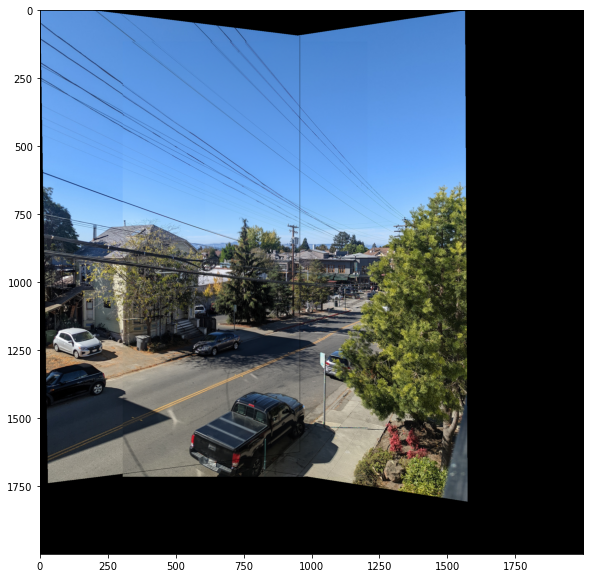

In [141]:
y, x = np.mgrid[0:car1.shape[0], 0:car1.shape[1]]
# new_m3 = np.zeros_like(new_ww2)
car3 = np.zeros((3100, 3000, 3))
bias1 = int(shift8[0])
bias2 = int(shift8[1])
y2, x2 = np.mgrid[0:car2.shape[0], 0:car2.shape[1]]
# test3 = np.zeros_like(test2)
car4 = np.zeros((3100, 3000, 3))
car4[y2, x2-bias2] = car2
car3[y+bias1, x] = car1
# combinecar = (3/4*car3 + 3/4*car4)
combinecar = weightAvg(car3, car4)
plt.figure(figsize=(10,10))
plt.imshow(combinecar[:2000,:2000,:].astype(int))